# Compare different models - TEMPLATE

This template can be used to:
- Compare different (RC) Models for time-series prediction statistically
- Sweep one hyperparameter of the models (e.g. the reservoir dimension)
- Save and load the results
- Visualize the results

In [1]:
import rescomp
import rescomp.statistical_tests as st
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

### For saving and loading results:

- Define the path 
- Select wether you want to load or save, when running this notebook

In [2]:
pre_path = r"C:\Users\Dennis\Documents\FILES&INFO\WISSEN\STUDIUM\Master LMU\Masterthesis\Simulations_2/"
name = "22_11_2021_Lorenz_Pathak_real8_rnl"

path = pre_path + name + "/"
parameter_path = path + "parameters/"
results_path = path + "/results/" 

load = False

system_flag = "Lorenz" # KS, Lorenz


load_parameters = load
load_results = load

### Parameter Dictionaries:
- **measure_p**: Defines the numpy seed, the error threshhold for the "valid_time" and the nr_of_model_realizations as a statistical test
- **time_p**: How the simulated time_series is cut into discard, train, sync, and predict periods
- **RC_p**: The Parameters for the RC models (which are the same for all). **Must be adjusted depending on the Experiment**. 
- **system_p**: The Parameters of the Data Simulation. **Must be adjusted depending on the Experiment**. 

In [3]:
# Parameters: Save or Load

if load_parameters:
    measure_p = np.load(parameter_path + 'measure_p.npy',allow_pickle='TRUE').item()
    time_p = np.load(parameter_path + 'time_p.npy',allow_pickle='TRUE').item()
    RC_p = np.load(parameter_path + 'RC_p.npy',allow_pickle='TRUE').item()
    system_p = np.load(parameter_path + 'system_p.npy',allow_pickle='TRUE').item()

else:
    # Measure parameters:
    measure_p = {}
    measure_p["seed"] = 1
    measure_p["error_threshhold"] = 0.4
    measure_p["nr_model_realizations"] = 10

    #Simulation Parameters: lorenz
    time_p = {}
    time_p["nr_of_time_intervals"] = 10
    time_p["dt"] = 0.1
    time_p["t_train_disc"] = 200 # (not given)
    time_p["t_train_sync"] = 10 # (not given)
    time_p["t_train"] = 100 
    time_p["t_pred_disc"] = 200 # (not given)
    time_p["t_pred_sync"] = 10 
    time_p["t_pred"] = 250
    
    #Simulation Parameters: KS
#     time_p = {}
#     time_p["nr_of_time_intervals"] = 4
#     time_p["dt"] = 0.25
#     time_p["t_train_disc"] = 5000 # (not given)
#     time_p["t_train_sync"] = 50 # (not given)
#     time_p["t_train"] = 5000 
#     time_p["t_pred_disc"] = 50 # (not given)
#     time_p["t_pred_sync"] = 10 
#     time_p["t_pred"] = 250
    
    

    # RC parameters
    RC_p = {} 
    RC_p["n_type_flag"] = "erdos_renyi_directed"
    RC_p["w_in_scale"] = 0.15# 1# 0.15
    RC_p["n_avg_deg"] = 3
    RC_p["n_rad"] = 0.4
    RC_p["gamma"] = 0.5
    RC_p["reg_param"] = 1e-6
    RC_p["w_in_sparse"] = True
    RC_p["w_in_ordered"] = False
    RC_p["act_fct_flag"] = "tanh_simple"
    RC_p["w_out_fit_flag"] = "linear_and_square_r_alt" 
    RC_p["reservoir_dim"] = 200


    # KS Parameters:
    if system_flag == "KS":
        system_p = {}
        system_p["lyapunov"] = 0.07
        system_p["system_size"] = 35
        system_p["dimensions"] = 64 # TODO: Bug when 35 
        system_p["eps"] = 0.08
    
    # Lorenz Parameters:
    if system_flag == "Lorenz":
        system_p = {}
        system_p["lyapunov"] = 0.9056
        system_p["a"] = 10
        system_p["b"] = 28 # TODO: Bug when 35 
        system_p["c"] = 8/3
        system_p["eps"] = 0.1
    
    
    Path(parameter_path).mkdir(parents=True, exist_ok=True)
    
    np.save(parameter_path + 'measure_p.npy', measure_p)
    np.save(parameter_path + 'time_p.npy', time_p)
    np.save(parameter_path + 'RC_p.npy', RC_p)
    np.save(parameter_path + 'system_p.npy', system_p)

In [4]:
# Print parameters:

print("______________________")
print("Measurement parameters: ")
for key, val in measure_p.items():
    print(f"{key}: {val}")
print("______________________")
print("Simulation parameters: ")
for key, val in time_p.items():
    print(f"{key}: {val}")
print("______________________")
print("RC parameters: ")
for key, val in RC_p.items():
    print(f"{key}: {val}")
print("______________________")
print(f"{system_flag} Parameters: ")
for key, val in system_p.items():
    print(f"{key}: {val}")

______________________
Measurement parameters: 
seed: 1
error_threshhold: 0.4
nr_model_realizations: 10
______________________
Simulation parameters: 
nr_of_time_intervals: 10
dt: 0.1
t_train_disc: 200
t_train_sync: 10
t_train: 100
t_pred_disc: 200
t_pred_sync: 10
t_pred: 250
______________________
RC parameters: 
n_type_flag: erdos_renyi_directed
w_in_scale: 0.15
n_avg_deg: 3
n_rad: 0.4
gamma: 0.5
reg_param: 1e-06
w_in_sparse: True
w_in_ordered: False
act_fct_flag: tanh_simple
w_out_fit_flag: linear_and_square_r_alt
reservoir_dim: 200
______________________
Lorenz Parameters: 
lyapunov: 0.9056
a: 10
b: 28
c: 2.6666666666666665
eps: 0.1


### Load the Parameter Dictionary values into python variables (convenience):

In [5]:
# Create variables according to dict name:

for d in (measure_p, time_p, RC_p, system_p):
    locals().update(d)

### Set the numpy seed:

In [6]:
# set seed:
if not load_results:
    np.random.seed(seed)

### Create Dataset:

- first define a function called *create_data* that takes only time_steps as an input
- use the *rescomp.statistical_tests.data_simulation* function to create the data

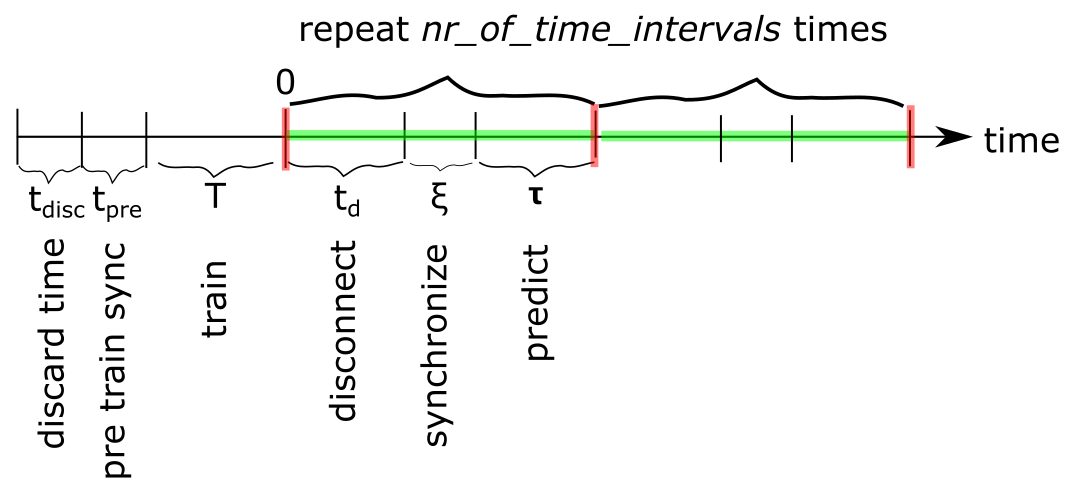

In [7]:
# KS: Function that creates the data as 2D numpy array of shape (time_steps, dim). 

if system_flag == "KS":
    if not load_results:
        def create_data(time_steps):
            return rescomp.simulate_trajectory(
            sys_flag='kuramoto_sivashinsky', dimensions=dimensions, system_size=system_size, dt=dt,
            time_steps=time_steps, eps = 0.0)

# Lorenz: Function that creates the data as 2D numpy array of shape (time_steps, dim). 
if system_flag == "Lorenz":
    if not load_results:
        def create_data(time_steps):
            starting_point = np.array([-14.03020521, -20.88693127, 25.53545])
            return  rescomp.simulate_trajectory(
            sys_flag='lorenz', dt=dt, time_steps=time_steps,
            starting_point=starting_point)

In [8]:
train_sync_steps = int(t_train_sync/dt)
pred_steps = int(t_pred/dt)
pred_sync_steps = int(t_pred_sync/dt)

if not load_results:
    x_train, x_pred_list, sim_data = st.data_simulation(create_data, t_train_disc, t_train_sync, t_train,
                                                         t_pred_disc, t_pred_sync, t_pred, dt, nr_of_time_intervals, 
                                                         sim_data_return = True)

train_disc_steps:  2000
train_sync_steps:  100
train_steps:  1000
pred_disc_steps:  2000
pred_sync_steps:  100
pred_steps:  2500
total_time_steps:  49100
................................
x_train shape:  (1100, 3)
x_pred_list shape : (10, 2601, 3)
sim_data shape : (49100, 3)


### Functions that define the different models, and the hyperparameter to be sweeped:

- Error: The function that defines the "Error" between the predicted and original time-series
- The functions for each Model use the *rescomp.statistical_tests.StatisticalModelTester* class

In [9]:
# Specific for system

Error = lambda y_pred, y_test: rescomp.measures.error_over_time(y_pred, y_test, 
                                                  distance_measure="L2", 
                                                  normalization="root_of_avg_of_spacedist_squared")

# Lorenz system:
if system_flag == "Lorenz":
    def variation_of_model(dt, eps = 0.0):

        model = lambda x: rescomp.simulations._normal_lorenz(x, sigma=a, rho=b*(1+eps), beta=c)
        model_pred = lambda x: rescomp.simulations._runge_kutta(model, dt, x)

        return model_pred

# random non-linearity as test:
if system_flag == "Lorenz":
    def random_model(x):
        return np.array((x[0]*x[1]*x[2], x[0]*x[2]+x[1], x[0]*(x[1] - x[2])))
    def variation_of_model(dt, eps = 0.0):

        model = lambda x: random_model(x)
        model_pred = lambda x: rescomp.simulations._runge_kutta(model, dt, x)

        return model_pred

# KS System:
if system_flag == "KS":
    def variation_of_model(dt, eps = 0.0):
        def model_pred(x):
            sim = rescomp.simulate_trajectory(
                sys_flag='kuramoto_sivashinsky', dimensions=dimensions, system_size=system_size, dt=dt,
                time_steps=2, starting_point = x, eps = eps) # Only simulate one time Step
            return sim[-1, :]
        return model_pred


# Specific for Experiment


def create_stat_tester_model_based(eps):
    ST = st.StatisticalModelTester()
    
    model_pred = variation_of_model(dt, eps = eps)
    
    def model_prediction_function(x_pred, model):
        x_pred_no_sync = x_pred[pred_sync_steps:, :]
        y_test = x_pred_no_sync[1:]
        y_pred = np.zeros(x_pred_no_sync.shape)
        y_pred = y_pred[1:]
        x_0 = x_pred_no_sync[0]
        x_i = x_0
        for i in range(0, pred_steps-1):
            x_i = model_pred(x_i)
            y_pred[i, :] = x_i
        return y_pred, y_test
    
    ST.set_model_prediction_function(model_prediction_function)
    ST.set_error_function(Error)
    return ST


def create_stat_tester_HRC(mode, gamma, eps, n_dim, reg_param):
    '''
    Hybrid RC
    mode: "full_hybrid", "input_hybrid", "output_hybrid"
    '''
    ST = st.StatisticalModelTester()
    # print("mode: ", mode)
    if mode == "full_hybrid":
        add_model_to_input = True
        add_model_to_output = True
    elif mode == "input_hybrid":
        add_model_to_input = True
        add_model_to_output = False
    elif mode == "output_hybrid":
        add_model_to_input = False
        add_model_to_output = True
        
    model_pred = variation_of_model(dt, eps = eps)
    
    def model_creation_function():

        esn = rescomp.esn.ESNHybrid()
        esn.create_network(n_dim = n_dim, n_rad=n_rad, n_avg_deg=n_avg_deg, n_type_flag=n_type_flag)
        esn.set_model(model_pred, add_model_to_input = add_model_to_input, 
                      add_model_to_output = add_model_to_output, gamma = gamma)
        esn.train(x_train = x_train, sync_steps = train_sync_steps, reg_param=reg_param, w_in_scale=w_in_scale,
              w_in_sparse = w_in_sparse, w_in_ordered=w_in_ordered, act_fct_flag=act_fct_flag, 
             w_out_fit_flag = w_out_fit_flag)
        return esn
    
    def model_prediction_function(x_pred, model):
        y_pred, y_test  = model.predict(x_pred, sync_steps=pred_sync_steps)
        return y_pred, y_test
    
    ST.set_model_creation_function(model_creation_function)
    ST.set_model_prediction_function(model_prediction_function)
    ST.set_error_function(Error)
    return ST


def create_stat_tester_NRC(reg_param, n_dim):
    '''
    Normal RC
    '''
    ST = st.StatisticalModelTester()
    
    def model_creation_function():
        esn = rescomp.esn.ESNWrapper()
        esn.create_network(n_dim = n_dim, n_rad=n_rad, n_avg_deg=n_avg_deg, n_type_flag=n_type_flag)
        esn.train(x_train = x_train, sync_steps = train_sync_steps, reg_param=reg_param, w_in_scale=w_in_scale,
              w_in_sparse = w_in_sparse, w_in_ordered=w_in_ordered, act_fct_flag=act_fct_flag, 
             w_out_fit_flag = w_out_fit_flag)
        return esn
    
    def model_prediction_function(x_pred, model):
        y_pred, y_test  = model.predict(x_pred, sync_steps=pred_sync_steps)
        return y_pred, y_test
    
    ST.set_model_creation_function(model_creation_function)
    ST.set_model_prediction_function(model_prediction_function)
    ST.set_error_function(Error)
    return ST

### Defining the sweep parameter array and wether calculation time and example_trajectories should be saved:

In [10]:
if load_results:
    time_it = False
    save_example_trajectory = False
    results_dict = st.load_results(results_path)
    locals().update(results_dict)
    if "times_models" in results_dict.keys():
        time_it = True
    if "example_trajectories_models" in results_dict.keys():
        save_example_trajectory = True    
    
    # Sweep parameters:
    sweep_variable_name, sweep_variable_list = list(list(sweep_array_models.values())[0].items())[0]
        

else:
    time_it = True
    save_example_trajectory = True
    output_flag = "valid_times_median_quartile"
    
    # Experiment parameters:
    n_dims = np.linspace(100, 1300, 13, endpoint=True, dtype = int)
    sweep_variable_list = n_dims
    sweep_variable_name = "reseroir_dim"
    
#     reg_params = np.logspace(-13, -2, 12)
#     sweep_variable_list = reg_params
#     sweep_variable_name = "reg_param"
    
#     gammas = np.linspace(0.0, 1.0, 6)
#     sweep_variable_list = gammas
#     sweep_variable_name = "gamma"
    
#     epss = [0.0, 0.01, 0.05, 0.1, 1]
#     epss = np.linspace(0.0, 0.1, 10, endpoint=True)
#     epss = np.linspace(0.0, 10, 11, endpoint=True)
#     sweep_variable_list = epss
#     sweep_variable_name = "eps"
    
    sweeped_variable_dict = {sweep_variable_name: sweep_variable_list}

print(f"{sweep_variable_name}: {sweep_variable_list}")

reseroir_dim: [ 100  200  300  400  500  600  700  800  900 1000 1100 1200 1300]


### RUN THE EXPERIMENT:

In [11]:
models_to_test = ["model_based", "normal", "full_hybrid", "input_hybrid", "output_hybrid"]
# models_to_test = ["normal", "full_hybrid", "input_hybrid", "output_hybrid"]

In [12]:
if not load_results:
    
    # Dict with ESN ST creation functions:
    ST_esn_creation_dict = {}
    if "normal" in models_to_test:
        ST_esn_creation_dict["normal"] = lambda sweep_var: create_stat_tester_NRC(reg_param = reg_param, 
                                                                                 n_dim = sweep_var) # CHANGE HERE

    for hybrid_key in ["full_hybrid","input_hybrid", "output_hybrid"]:
        if hybrid_key in models_to_test:
            def func_factory(hybrid_key):
                return lambda sweep_var: create_stat_tester_HRC(hybrid_key, eps = eps,
                                                                gamma = gamma,
                                                                reg_param = reg_param, 
                                                                n_dim = sweep_var) # CHANGE HERE #reservoir_dim

            ST_esn_creation_dict[hybrid_key] = func_factory(hybrid_key)
    
    results_models = {}
    sweep_array_models = {}
    output_flags_models = {}

    if time_it:
        times_models = {}
    if save_example_trajectory:
        example_trajectories_models = {}

    if "model_based" in models_to_test:
        print("=== Simulation Model based prediction ===")
        model_name = "model_based"
        ST_model_based_creation = lambda sweep_var: create_stat_tester_model_based(eps = eps) # CHANGE HERE

        model_based_sweeper = st.ST_sweeper(sweeped_variable_dict = sweeped_variable_dict, 
                                        ST_creator_function = ST_model_based_creation,
                                        model_name = model_name,
                                        saving_pre_path = results_path, 
                                        artificial_sweep = False)
        out = model_based_sweeper.sweep(nr_model_realizations = 1, 
                                    x_pred_list = x_pred_list, 
                                    output_flag = output_flag, 
                                    save_example_trajectory = save_example_trajectory, 
                                    time_it = time_it, 
                                    error_threshhold = error_threshhold)

        results_models[model_name] = out[0]
        if time_it:
            times_models[model_name] = out[1]
        if save_example_trajectory:
            example_trajectories_models[model_name] = out[2]



    #### THE RC MODELS:
    print("=== Starting RC calculations ===")
    for esn_key, ST_esn_creation in ST_esn_creation_dict.items():
        RC_sweeper = st.ST_sweeper(sweeped_variable_dict = sweeped_variable_dict, 
                                    ST_creator_function = ST_esn_creation,
                                    model_name = esn_key,
                                    saving_pre_path = results_path, 
                                    artificial_sweep = False)
        out = RC_sweeper.sweep(nr_model_realizations = nr_model_realizations, 
                               x_pred_list = x_pred_list, 
                               output_flag = output_flag, 
                               save_example_trajectory = save_example_trajectory, 
                               time_it = time_it, 
                               error_threshhold = error_threshhold)
        results_models[esn_key] = out[0]
        if time_it:
            times_models[esn_key] = out[1]
        if save_example_trajectory:
            example_trajectories_models[esn_key] = out[2]

    for key in results_models.keys():
        sweep_array_models[key] = sweeped_variable_dict
        output_flags_models[key] = output_flag

=== Simulation Model based prediction ===
STARTING SWEEP FOR MODEL: model_based
reseroir_dim: 100
      Starting ensemble experiment...
      output_flag:  valid_times_median_quartile
Realization: 1/1 ...


C:\Users\Dennis\anaconda3\envs\rc_env_np16p6\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Dennis\anaconda3\envs\rc_env_np16p6\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
c:\users\dennis\documents\github\rescomp\rescomp\simulations.py:338: RuntimeWarning: invalid value encountered in add
  return y + 1. / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
c:\users\dennis\documents\github\rescomp\rescomp\measures.py:221: RuntimeWarning: invalid value encountered in greater
  bool_array = error_series > epsilon
c:\users\dennis\documents\github\rescomp\rescomp\simulations.py:335: RuntimeWarning: invalid value encountered in add
  k2 = dt * f(y + k1 / 2)
C:\Users\Dennis\anaconda3\envs\rc_env_np16p6\lib\site-packages\numpy\linalg\linalg.py:2480: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real


reseroir_dim: 200
      Starting ensemble experiment...
      output_flag:  valid_times_median_quartile
Realization: 1/1 ...
reseroir_dim: 300
      Starting ensemble experiment...
      output_flag:  valid_times_median_quartile
Realization: 1/1 ...
reseroir_dim: 400
      Starting ensemble experiment...
      output_flag:  valid_times_median_quartile
Realization: 1/1 ...
reseroir_dim: 500
      Starting ensemble experiment...
      output_flag:  valid_times_median_quartile
Realization: 1/1 ...
reseroir_dim: 600
      Starting ensemble experiment...
      output_flag:  valid_times_median_quartile
Realization: 1/1 ...
reseroir_dim: 700
      Starting ensemble experiment...
      output_flag:  valid_times_median_quartile
Realization: 1/1 ...
reseroir_dim: 800
      Starting ensemble experiment...
      output_flag:  valid_times_median_quartile
Realization: 1/1 ...
reseroir_dim: 900
      Starting ensemble experiment...
      output_flag:  valid_times_median_quartile
Realization: 1/1 ...


c:\users\dennis\documents\github\rescomp\rescomp\esn.py:538: RuntimeWarning: invalid value encountered in matmul
  return np.tanh(self._w_in @ x + self._network @ r)
c:\users\dennis\documents\github\rescomp\rescomp\esn.py:1368: RuntimeWarning: invalid value encountered in matmul
  y = self._w_out @ last_r_gen


Realization: 2/10 ...
Realization: 3/10 ...
Realization: 4/10 ...
Realization: 5/10 ...
Realization: 6/10 ...
Realization: 7/10 ...
Realization: 8/10 ...
Realization: 9/10 ...
Realization: 10/10 ...
reseroir_dim: 200
      Starting ensemble experiment...
      output_flag:  valid_times_median_quartile
Realization: 1/10 ...
Realization: 2/10 ...
Realization: 3/10 ...
Realization: 4/10 ...
Realization: 5/10 ...
Realization: 6/10 ...
Realization: 7/10 ...
Realization: 8/10 ...
Realization: 9/10 ...
Realization: 10/10 ...
reseroir_dim: 300
      Starting ensemble experiment...
      output_flag:  valid_times_median_quartile
Realization: 1/10 ...
Realization: 2/10 ...
Realization: 3/10 ...
Realization: 4/10 ...
Realization: 5/10 ...
Realization: 6/10 ...
Realization: 7/10 ...
Realization: 8/10 ...
Realization: 9/10 ...
Realization: 10/10 ...
reseroir_dim: 400
      Starting ensemble experiment...
      output_flag:  valid_times_median_quartile
Realization: 1/10 ...
Realization: 2/10 ...
Rea

Realization: 3/10 ...
Realization: 4/10 ...
Realization: 5/10 ...
Realization: 6/10 ...
Realization: 7/10 ...
Realization: 8/10 ...
Realization: 9/10 ...
Realization: 10/10 ...
STARTING SWEEP FOR MODEL: output_hybrid
reseroir_dim: 100
      Starting ensemble experiment...
      output_flag:  valid_times_median_quartile
Realization: 1/10 ...
Realization: 2/10 ...
Realization: 3/10 ...
Realization: 4/10 ...
Realization: 5/10 ...
Realization: 6/10 ...
Realization: 7/10 ...
Realization: 8/10 ...
Realization: 9/10 ...
Realization: 10/10 ...
reseroir_dim: 200
      Starting ensemble experiment...
      output_flag:  valid_times_median_quartile
Realization: 1/10 ...
Realization: 2/10 ...
Realization: 3/10 ...
Realization: 4/10 ...
Realization: 5/10 ...
Realization: 6/10 ...
Realization: 7/10 ...
Realization: 8/10 ...
Realization: 9/10 ...
Realization: 10/10 ...
reseroir_dim: 300
      Starting ensemble experiment...
      output_flag:  valid_times_median_quartile
Realization: 1/10 ...
Realiza

## PLOTTING:

### Median valid times with 1. and 3. quartile vs. sweep variable:

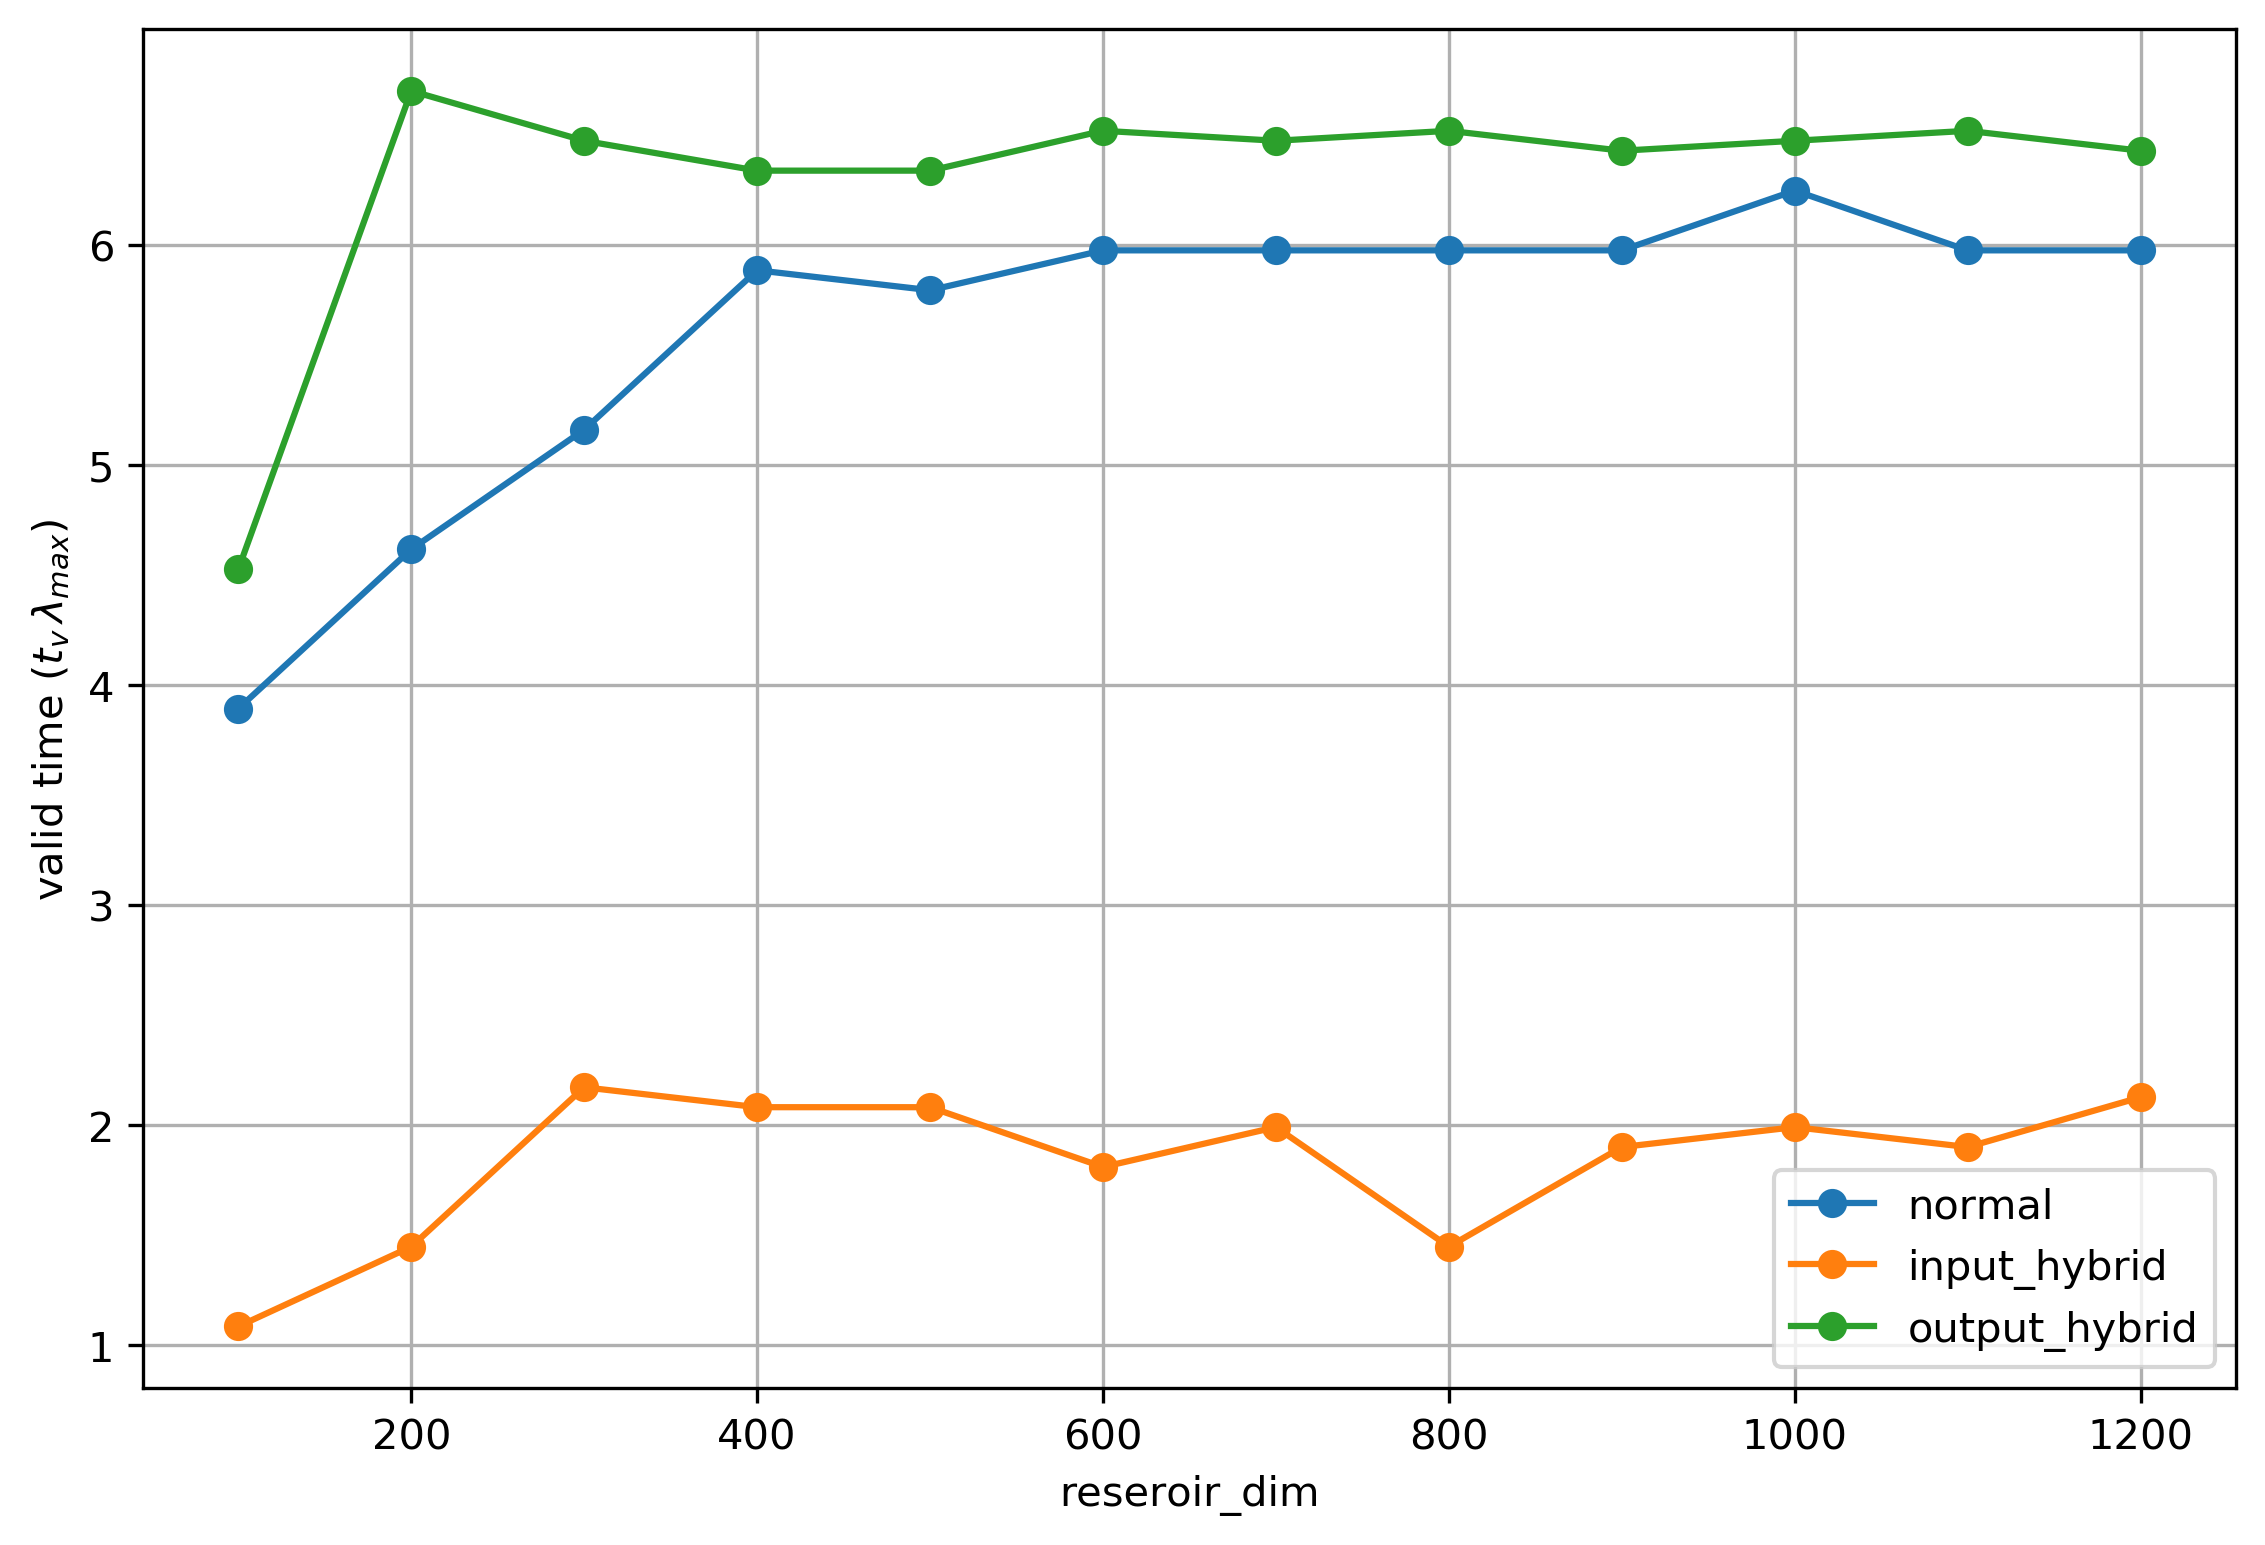

In [17]:
fig = plt.figure(figsize=(9, 6), dpi=300)
ax = fig.add_subplot(1, 1, 1)
to_show = ["normal", "input_hybrid",  "output_hybrid"]

scale = dt*lyapunov
start_index = 0
end_index = -1

for model_key, val in results_models.items():
    if not model_key in to_show:
        continue
    if output_flags_models[model_key] == "valid_times_median_quartile":
        median_list = val[start_index:end_index, 0]*scale
        fist_quartile_list = val[start_index:end_index, 1]*scale
        third_quartile_list = val[start_index:end_index, 2]*scale
        # ax.errorbar(list(sweep_array_models[model_key].values())[0][start_index:end_index], median_list, yerr=[median_list - fist_quartile_list, third_quartile_list - median_list], fmt='-o', label = model_key)
        ax.plot(list(sweep_array_models[model_key].values())[0][start_index:end_index], median_list, marker='o', label = model_key)
        # ax.set_xscale('log')
ax.set_xlabel(sweep_variable_name)
ax.set_ylabel("valid time $(t_v\, \lambda_{max})$")
plt.grid()
plt.legend()

### Calculation time (seconds) vs. sweep variable:

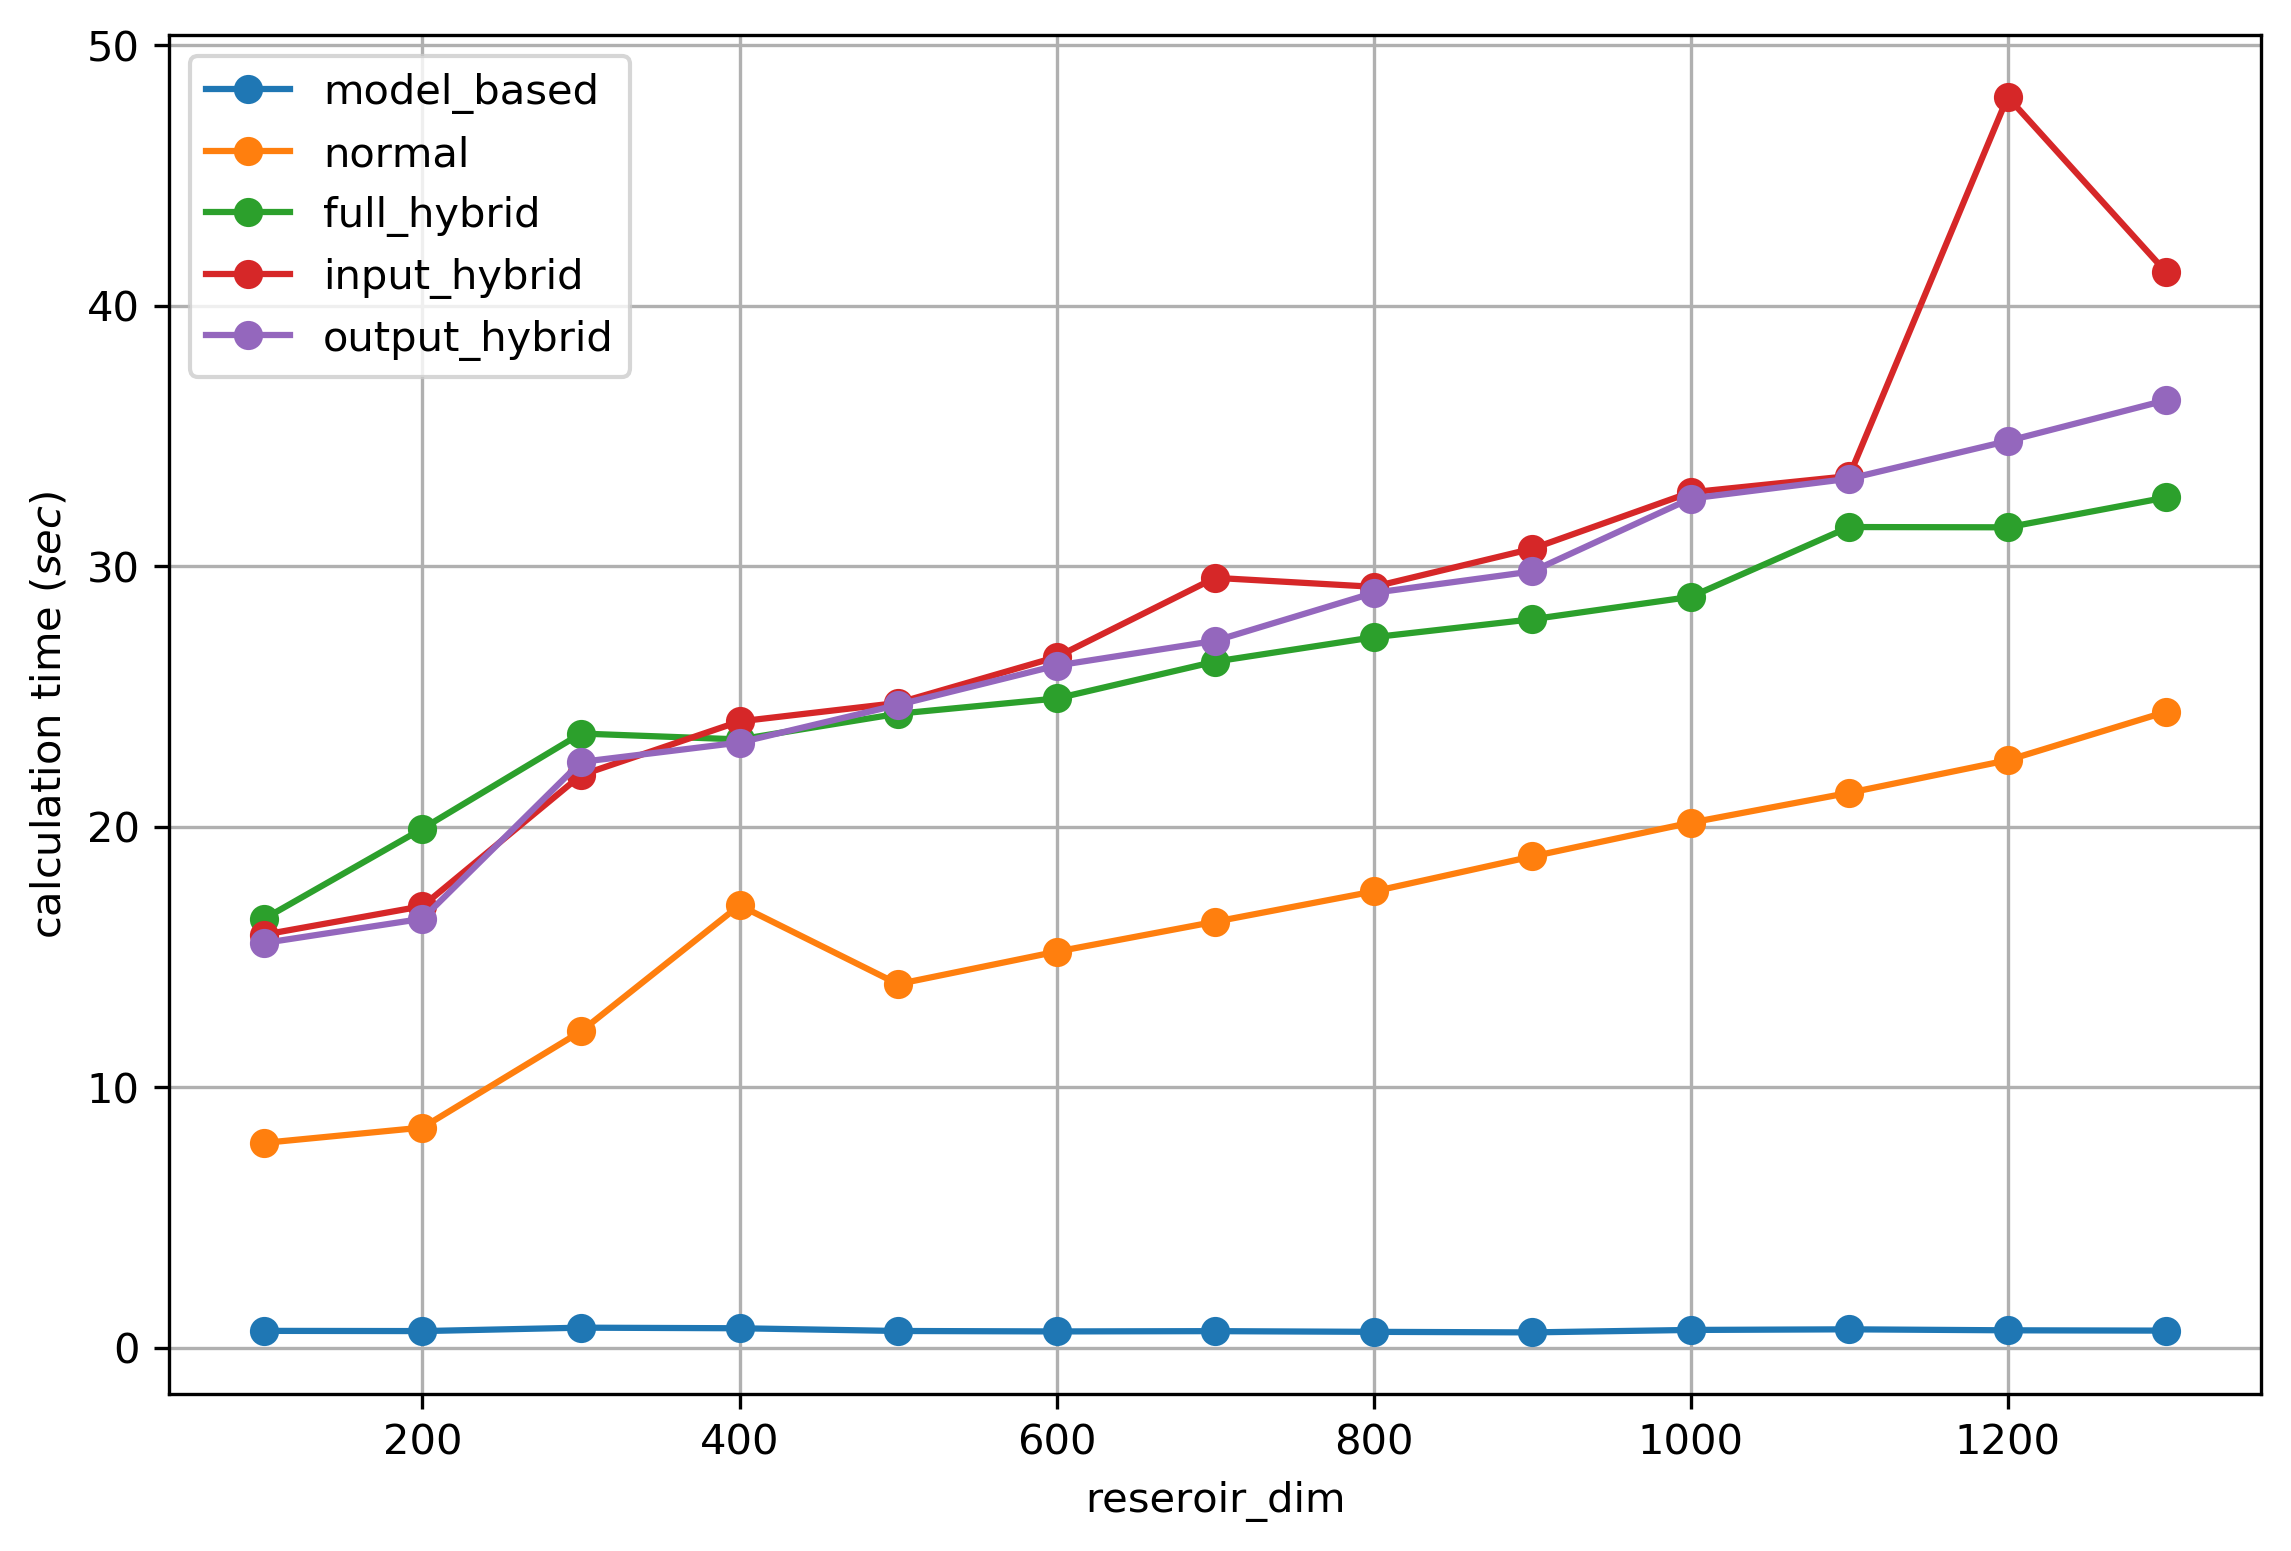

In [14]:
if time_it:

    fig = plt.figure(figsize=(9, 6), dpi=300)

    for model_key, val in times_models.items():
        # print(val)
        plt.plot(list(sweep_array_models[model_key].values())[0], val, label = model_key, marker='o')

    plt.xlabel(sweep_variable_name)
    plt.ylabel(r"calculation time $(sec)$")
    plt.grid()
    plt.legend()

### Example Trajectories:

#### 2D Images (e.g. KS-System):

..showing single trajectories: ..
reseroir_dim: 1200
SHOW DIFFERENCES to Sim:  False


C:\Users\Dennis\anaconda3\envs\rc_env_np16p6\lib\site-packages\numpy\linalg\linalg.py:2480: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
C:\Users\Dennis\anaconda3\envs\rc_env_np16p6\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater
C:\Users\Dennis\anaconda3\envs\rc_env_np16p6\lib\site-packages\matplotlib\image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
C:\Users\Dennis\anaconda3\envs\rc_env_np16p6\lib\site-packages\matplotlib\image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
C:\Users\Dennis\anaconda3\envs\rc_env_np16p6\lib\site-packages\matplotlib\image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
C:\Users\Dennis\anaconda3\envs\rc_env_np16p6\lib\site-packages\matplotlib\image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = n

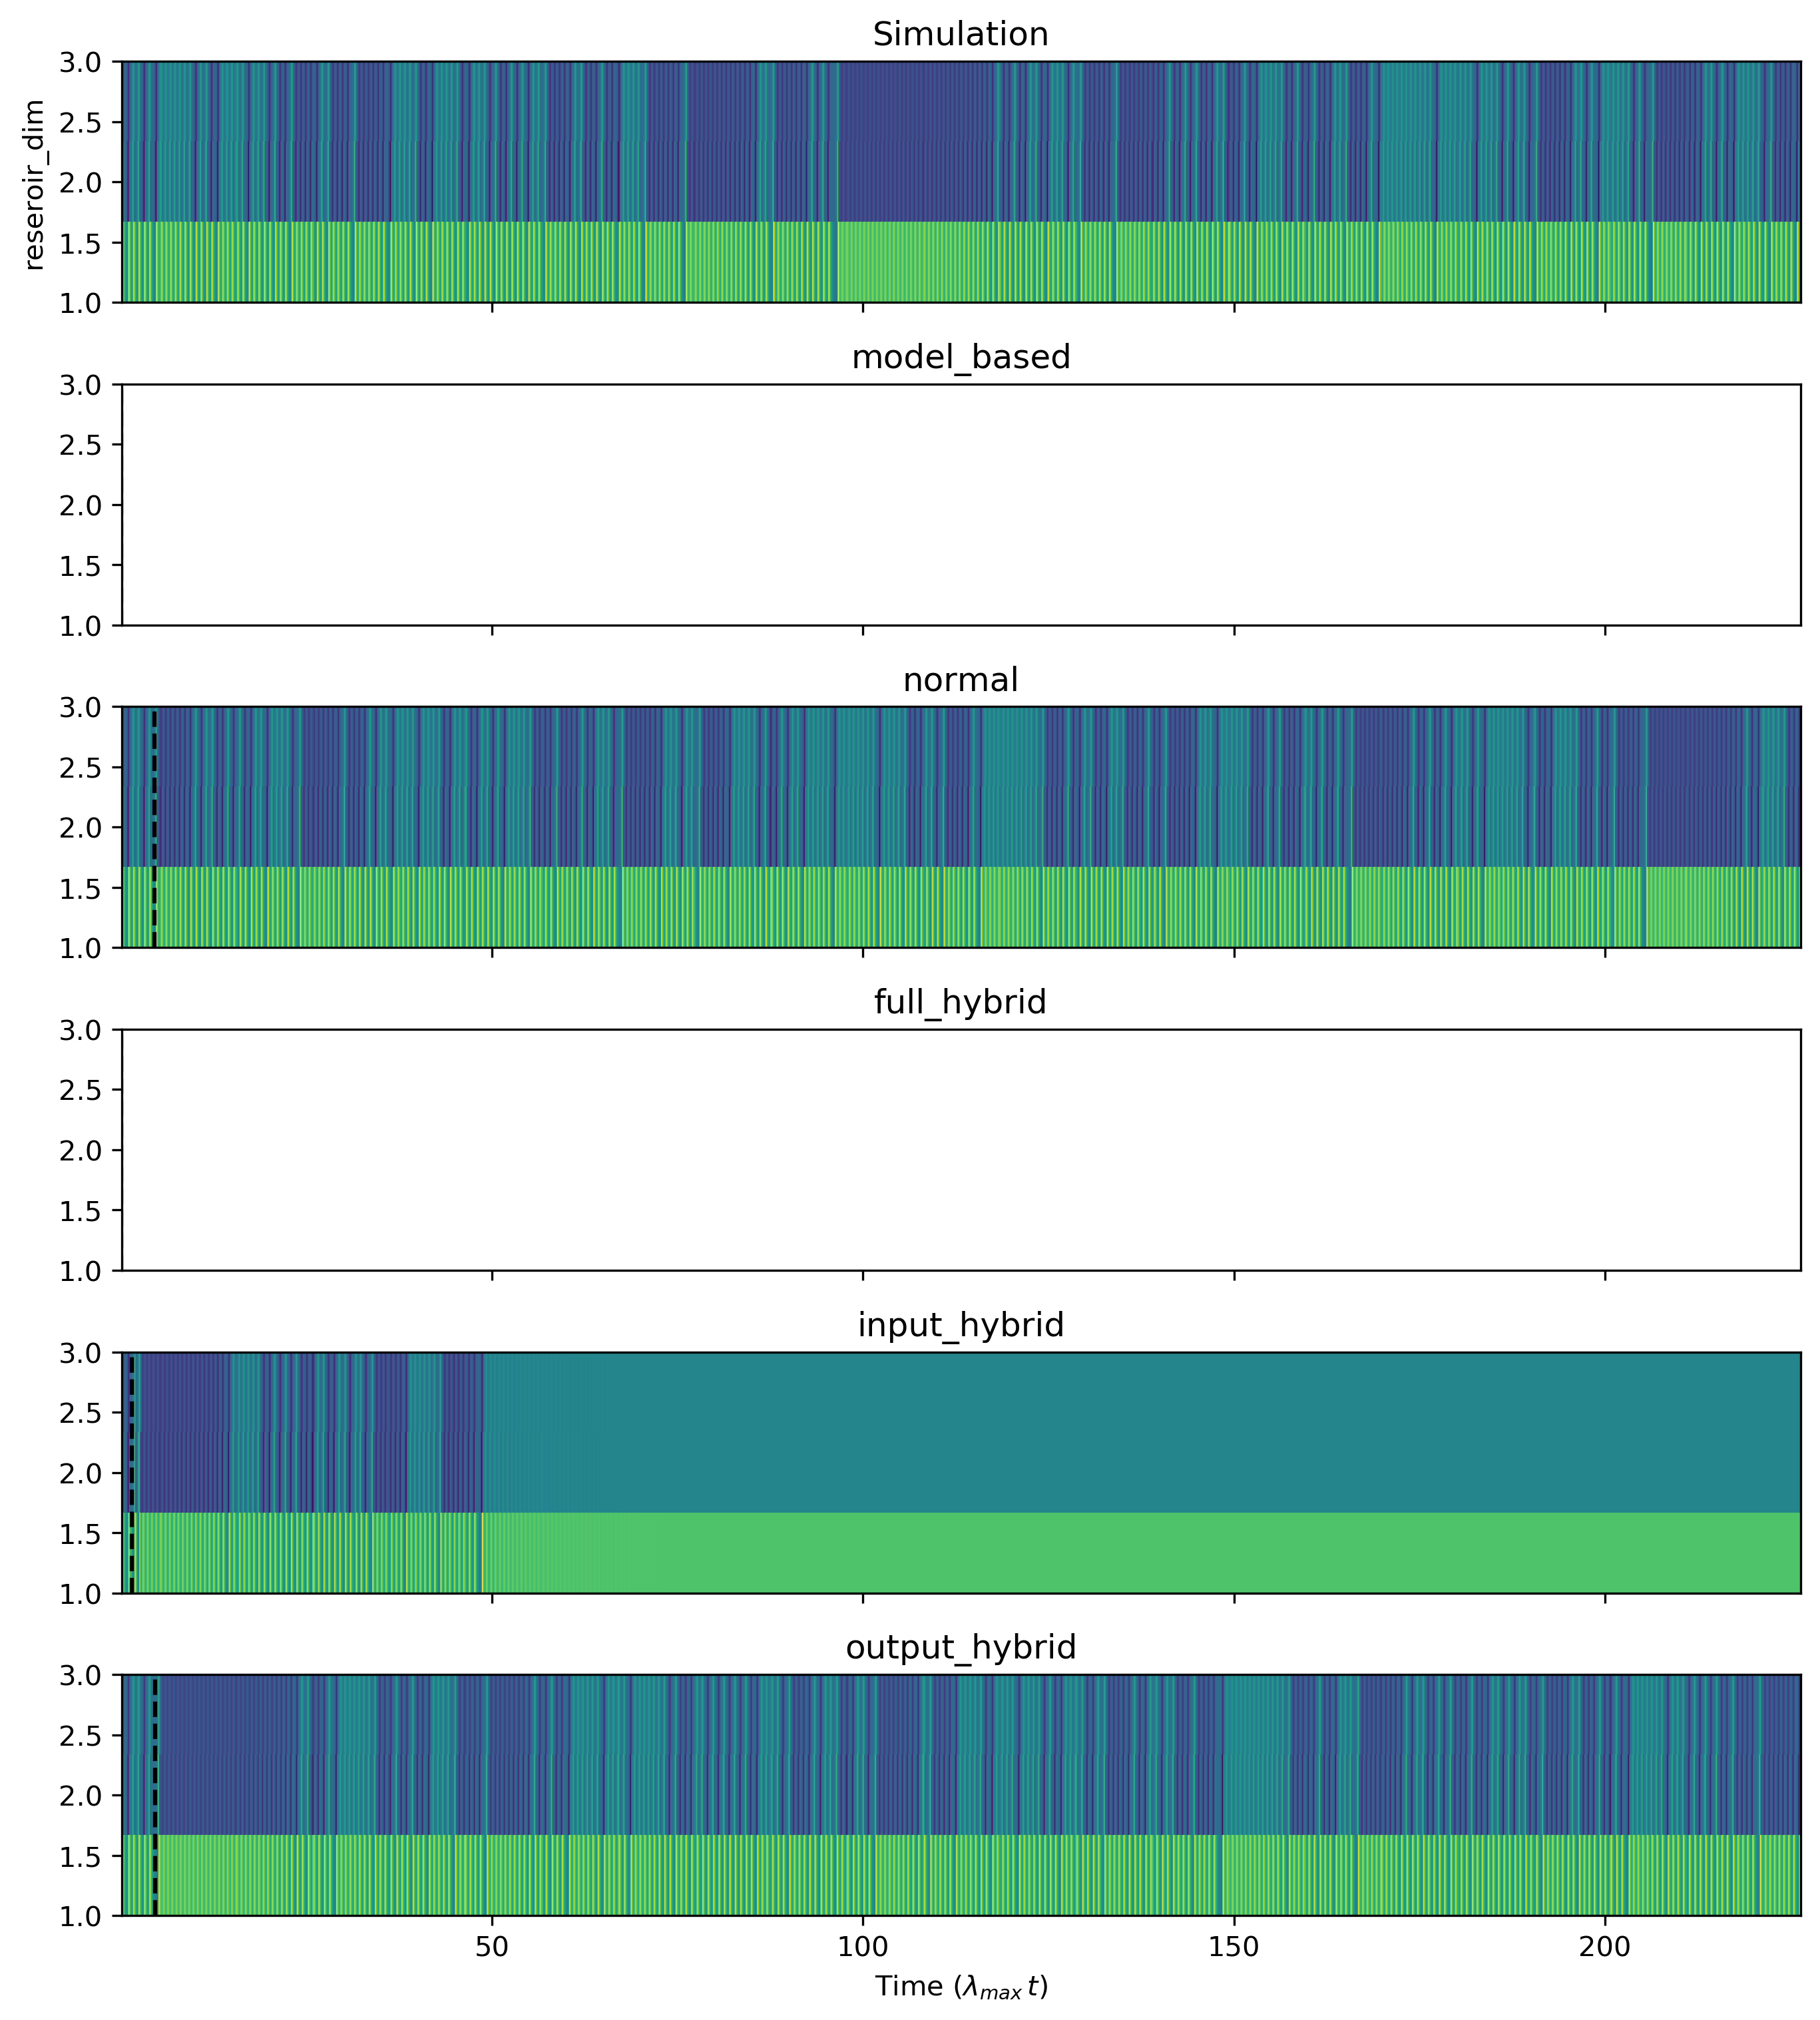

In [15]:
if save_example_trajectory:
    # Show single trajectories:
    ############################
    show_difference = False
    show_real_time = True
    use_joint_colors = False
    show_valid_time = True
    timeend = 10000

    sweep_i = -2 
    ###########################


    to_add = ""

    print("..showing single trajectories: ..")
    # Get sweep variable info:
    
    t = list(sweep_array_models.items())[0]
    sweep_variable_list = list(t[1].values())[0]
    sweep_variable_name = list(t[1].keys())[0]
    
    current_sweep_var = sweep_variable_list[sweep_i]
    print(f"{sweep_variable_name}: {current_sweep_var}")
    print("SHOW DIFFERENCES to Sim: ", show_difference)


    nr_of_models = len(example_trajectories_models.keys())

    fig, axs = plt.subplots(nr_of_models + 1, 1, sharex="all", figsize=(9, 10),
                                constrained_layout=True, dpi=300)
    

    counter = 1
    for model_key, example_trajectories in example_trajectories_models.items():
        if counter == 1:
            y_test = example_trajectories[sweep_i][1]
            if show_real_time:
                if timeend > pred_steps:
                    timeend = pred_steps

                x_label = r"Time $(\lambda_{max}\, t)$"
                dim = y_test.shape[-1]
                extent= [dt*lyapunov, timeend*dt*lyapunov, 1, dim]
            else:
                x_label = "time steps"
                extent = None
            ax = axs[0]
            im = ax.imshow(y_test.T, aspect='auto',extent = extent)
            ax.set_title("Simulation")
            if use_joint_colors:
                clim=im.properties()['clim']
            else:
                clim = None
        y_pred = example_trajectories[sweep_i][0]

        if show_valid_time:
            error_array = Error(y_pred, y_test)
            valid_time_index = np.argmax(error_array>error_threshhold)
            if show_real_time:
                valid_time = lyapunov*dt*valid_time_index
            else:
                valid_time = valid_time_index
        
        if show_difference:
            to_add = " (difference)"
            y_pred = y_pred - y_test

        ax = axs[counter]
        ax.imshow(y_pred.T, aspect='auto',  extent = extent, clim = clim) #vmin=vmin, vmax=vmax,
        if show_valid_time:
            ax.axvline(valid_time, color="k", linestyle="--")
        ax.set_title(model_key + to_add)
        counter += 1

    axs[0].set_ylabel(sweep_variable_name)
    axs[-1].set_xlabel(x_label)

    if use_joint_colors:
        fig.colorbar(im, ax=axs)

### Line plot (e.g. Lorenz System):

..showing single trajectories: ..
reseroir_dim: 1300
SHOW DIFFERENCES to Sim:  True


C:\Users\Dennis\anaconda3\envs\rc_env_np16p6\lib\site-packages\numpy\linalg\linalg.py:2480: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
C:\Users\Dennis\anaconda3\envs\rc_env_np16p6\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
C:\Users\Dennis\anaconda3\envs\rc_env_np16p6\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


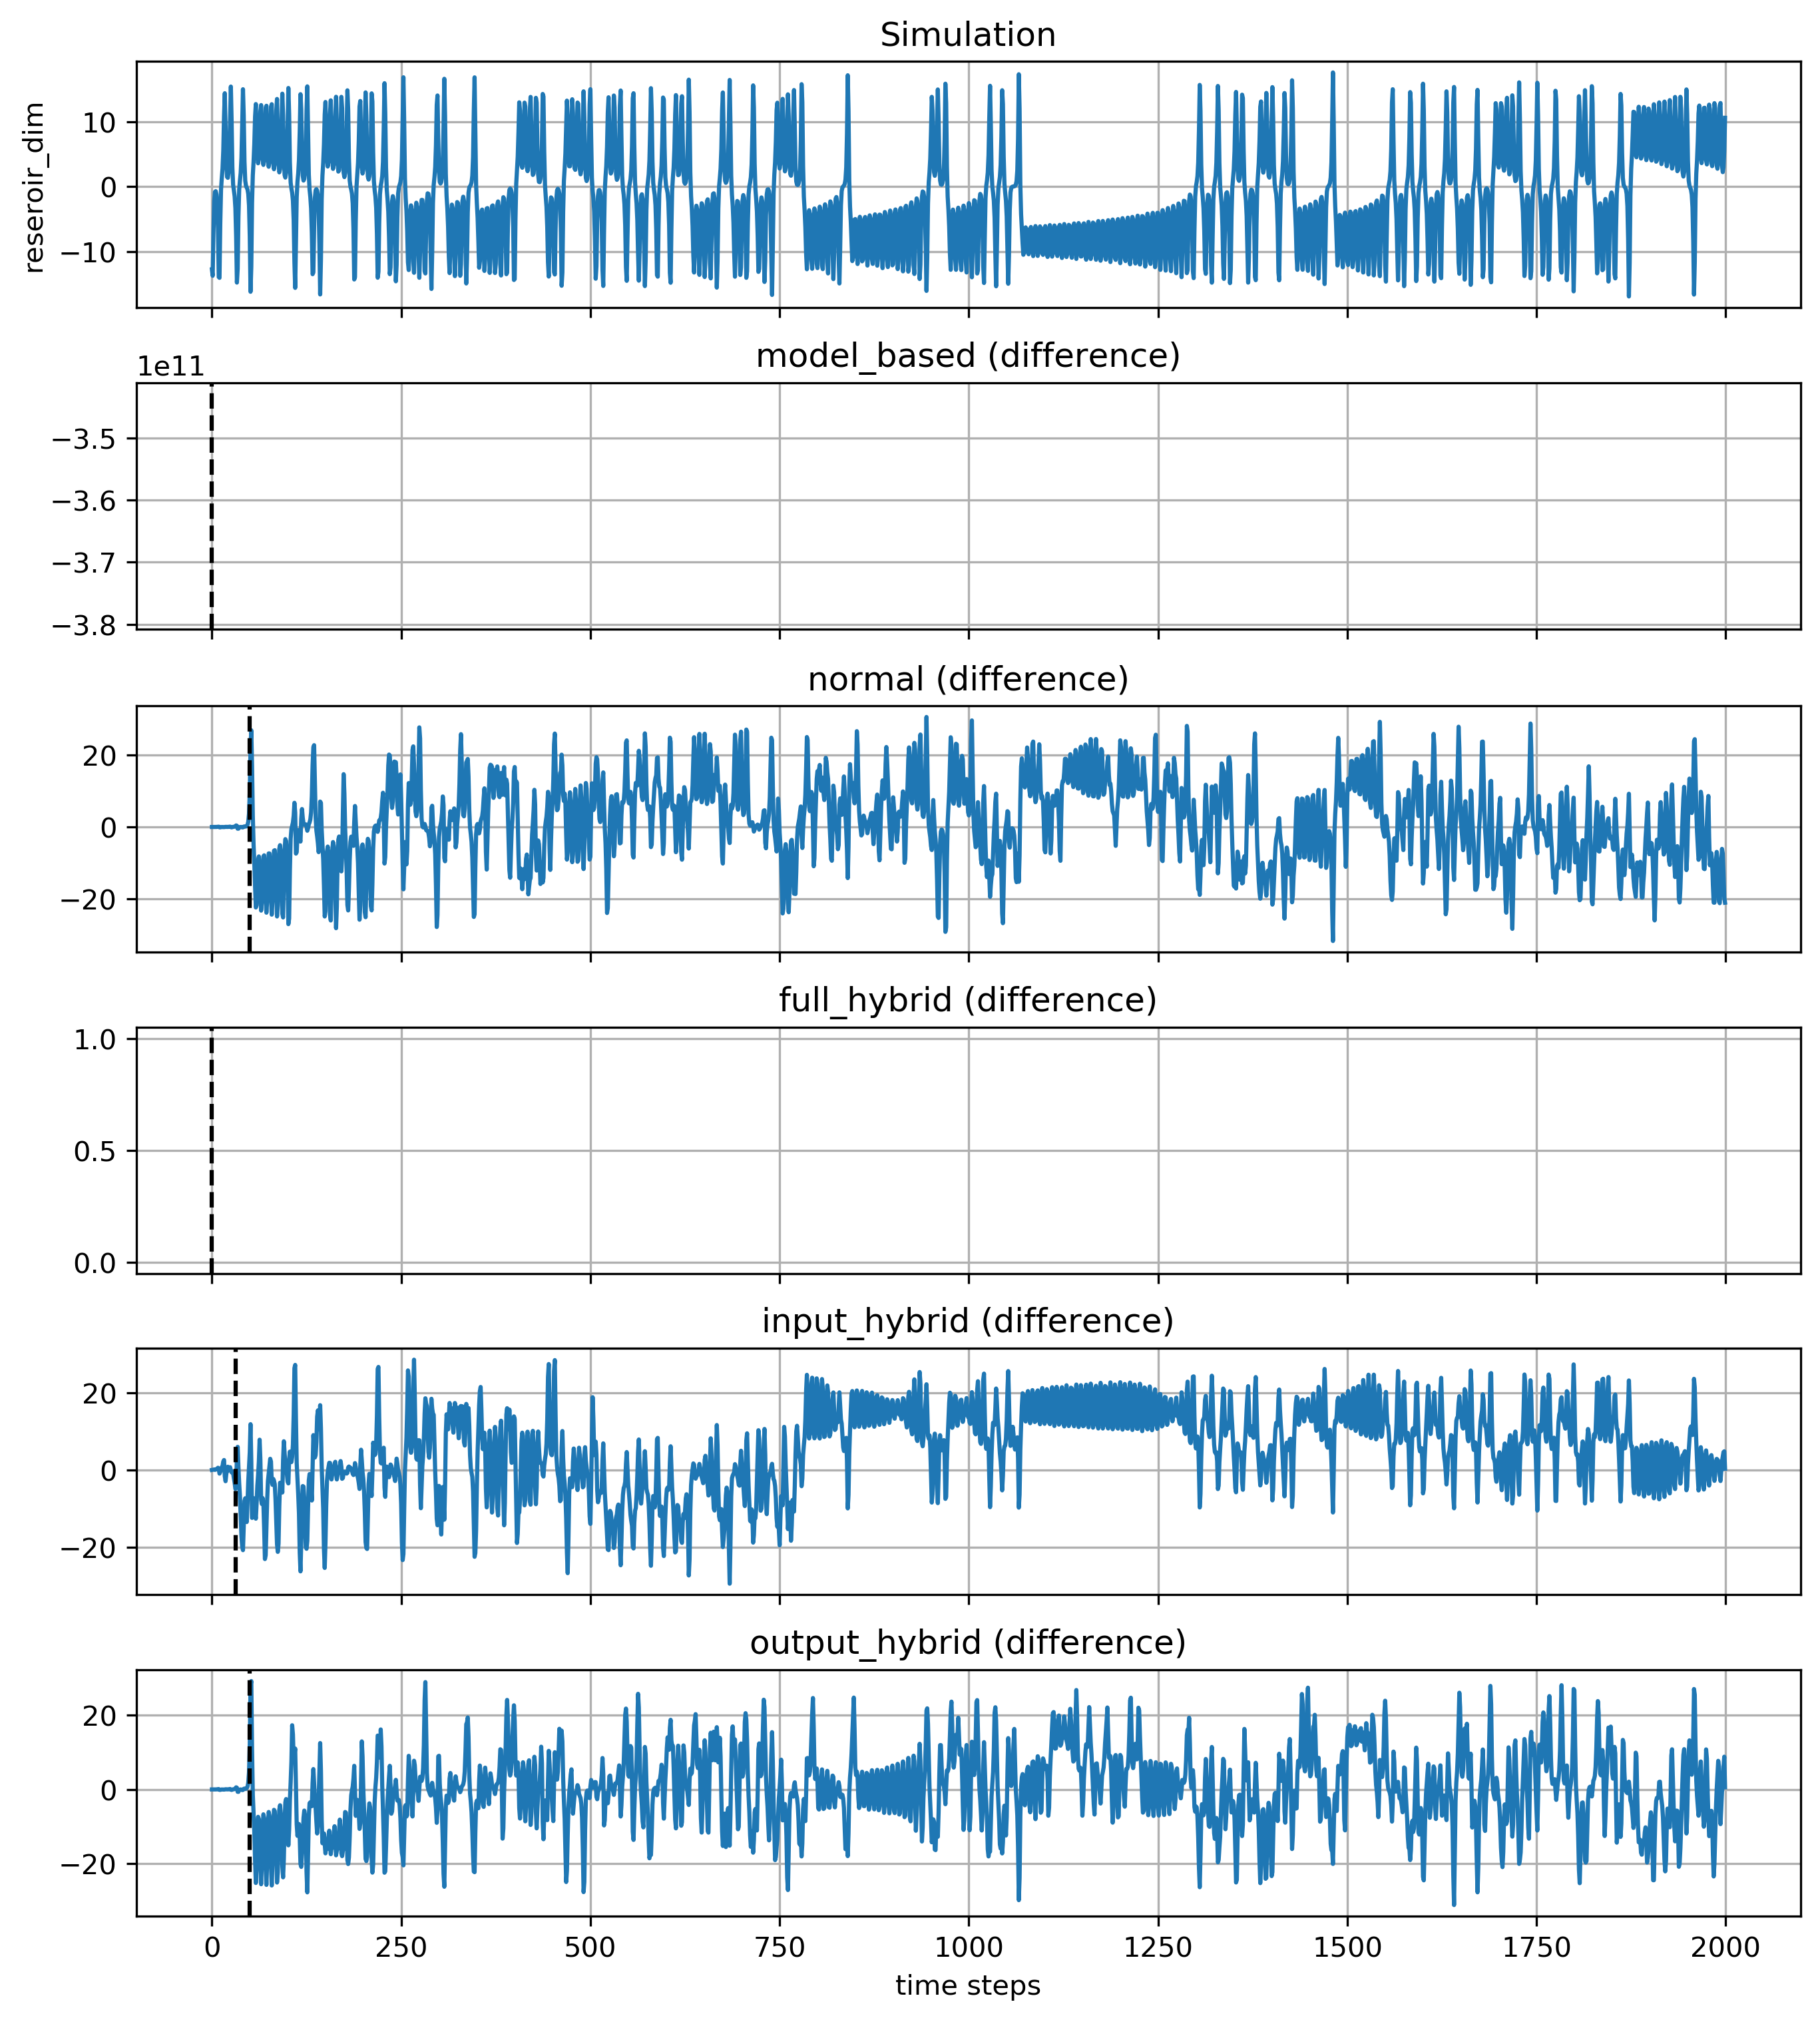

In [16]:
if save_example_trajectory:
    # Show single trajectories:
    ############################
    show_difference = True
    show_real_time = False
    show_valid_time = True
    timeend = 2000
    dimension_to_show = 0
    sweep_i = -1
    ###########################
    if timeend > pred_steps:
        timeend = pred_steps - 1
    if show_real_time:

        x_label = r"Time $(\lambda_{max}\, t)$"
        extent = np.linspace(dt*lyapunov, timeend*dt*lyapunov, timeend)
    else:
        x_label = "time steps"
        extent = np.arange(0, timeend, 1)
    to_add = ""

    print("..showing single trajectories: ..")
    # Get sweep variable info:
    
    t = list(sweep_array_models.items())[0]
    sweep_variable_list = list(t[1].values())[0]
    sweep_variable_name = list(t[1].keys())[0]
    
    current_sweep_var = sweep_variable_list[sweep_i]
    print(f"{sweep_variable_name}: {current_sweep_var}")
    print("SHOW DIFFERENCES to Sim: ", show_difference)


    nr_of_models = len(example_trajectories_models.keys())

    fig, axs = plt.subplots(nr_of_models + 1, 1, sharex="all", figsize=(9, 10),
                                constrained_layout=True, dpi=300)
    

    counter = 1
    for model_key, example_trajectories in example_trajectories_models.items():
        if counter == 1:
            y_test = example_trajectories[sweep_i][1]
            ax = axs[0]
            ax.plot(extent, y_test[:timeend, dimension_to_show])
            ax.set_title("Simulation")
            ax.grid()

        y_pred = example_trajectories[sweep_i][0]
    
    
        if show_valid_time:
            error_array = Error(y_pred, y_test)
            if np.max(error_array) < error_threshhold:
                valid_time_index = len(y_pred) - 1
            else:
                valid_time_index = np.argmax(error_array>error_threshhold)
            if show_real_time:
                valid_time = lyapunov*dt*valid_time_index
            else:
                valid_time = valid_time_index
        
        if show_difference:
            to_add = " (difference)"
            y_pred = y_pred - y_test

        ax = axs[counter]
        ax.plot(extent, y_pred[:timeend, dimension_to_show])
        if show_valid_time:
            ax.axvline(valid_time, color="k", linestyle="--")
        ax.set_title(model_key + to_add)
        ax.grid()
        counter += 1

    axs[0].set_ylabel(sweep_variable_name)
    axs[-1].set_xlabel(x_label)

    if use_joint_colors:
        fig.colorbar(im, ax=axs)

# Additional testing:

In [23]:
y_pred, y_test = example_trajectories_models["model_based"][sweep_i]

In [38]:
# np.isnan(y_pred).any()
has_infinite_or_nan = ~np.isfinite(y_test)
has_infinite_or_nan.any()

False

In [26]:
st.measures.valid_time_index(Error(y_pred, y_test), error_threshhold)

c:\users\dennis\documents\github\rescomp\rescomp\measures.py:221: RuntimeWarning: invalid value encountered in greater
  bool_array = error_series > epsilon


0

In [45]:
test = np.array([np.nan, ]*5)
test = np.array([-np.inf, ]*5)
test>error_threshhold

array([False, False, False, False, False])

In [46]:
Error(y_pred,y_test)

array([1.31582178e+10,            inf,            nan, ...,
                  nan,            nan, 7.30085187e-01])

In [24]:
y_pred

array([[-3.60919811e+011, -5.10940634e+007,  8.48308528e+007],
       [            -inf, -1.35233845e+248,  2.18932382e+248],
       [             nan,              nan,              nan],
       ...,
       [             nan,              nan,              nan],
       [             nan,              nan,              nan],
       [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000]])